In [1]:
!pip install pyPortfolioOpt
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
import yfinance as yf
yf.pdr_override()

%matplotlib inline

In [3]:
start_date = datetime.datetime(2021,4,1)
end_date = datetime.datetime(2023,3,31)

In [4]:
def get_stock_price(ticker):
    prices = web.get_data_yahoo(ticker,start_date,end_date)
    prices = prices["Adj Close"].dropna(how="all")
    return prices

In [6]:
ticker_list = ['INFY.NS','TCS.NS','TATAMOTORS.NS','MARUTI.NS',
	'SUNPHARMA.NS','CIPLA.NS','ITC.NS','MARICO.NS','GOLDBEES.NS']
portfolio = get_stock_price(ticker_list)

[*********************100%%**********************]  9 of 9 completed


In [7]:
portfolio.to_csv("portfolio.csv",index=True)
portfolio = pd.read_csv("portfolio.csv",parse_dates=True,index_col="Date")

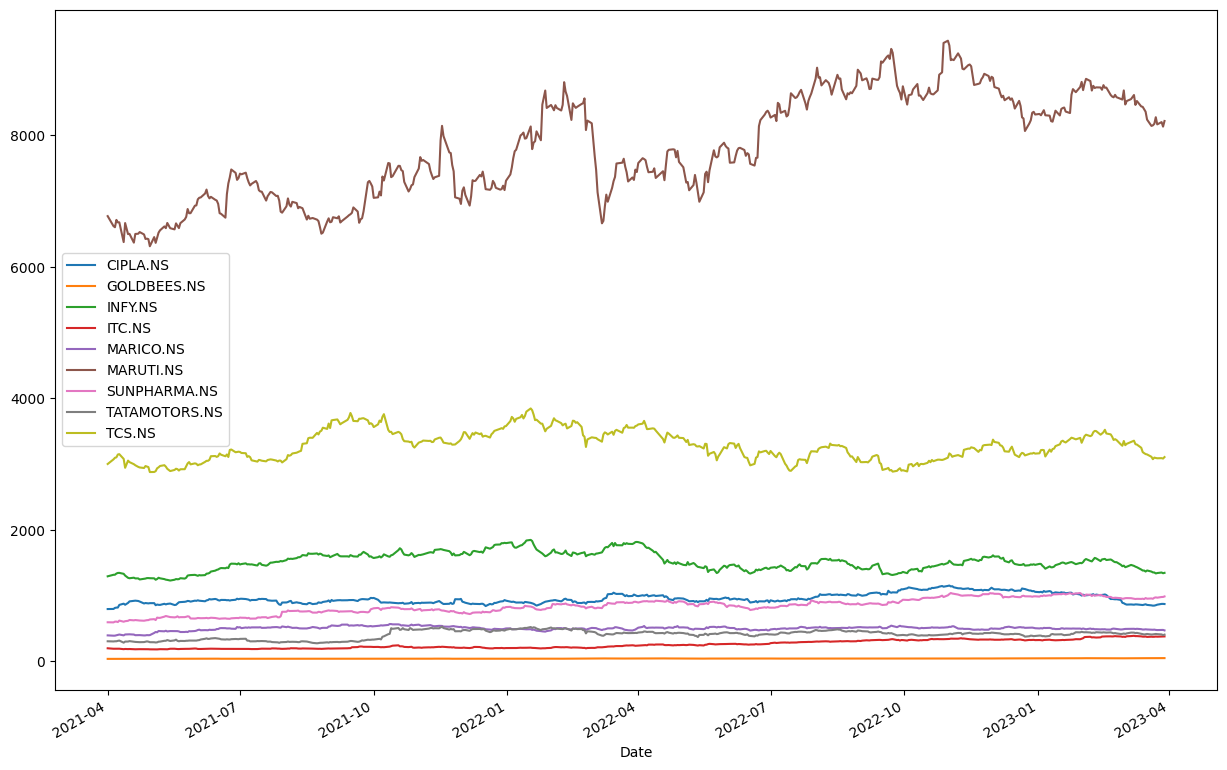

In [8]:
portfolio[portfolio.index >= "2021-04-01"].plot(figsize=(15,10));

In [ ]:
portfolio[portfolio.index >= "2021-04-01"].plot(figsize=(15,10));

In [9]:
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(portfolio, frequency=252)

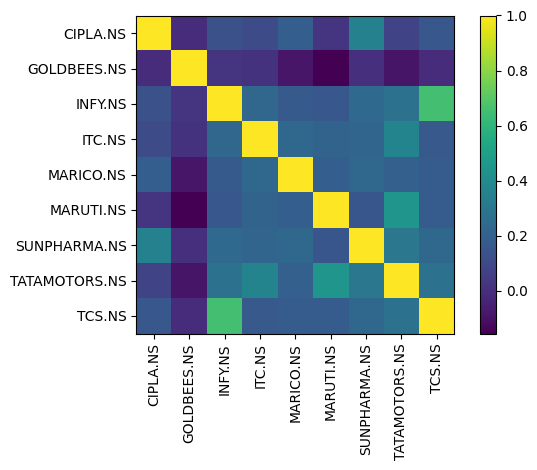

In [10]:
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);


In [11]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(portfolio)

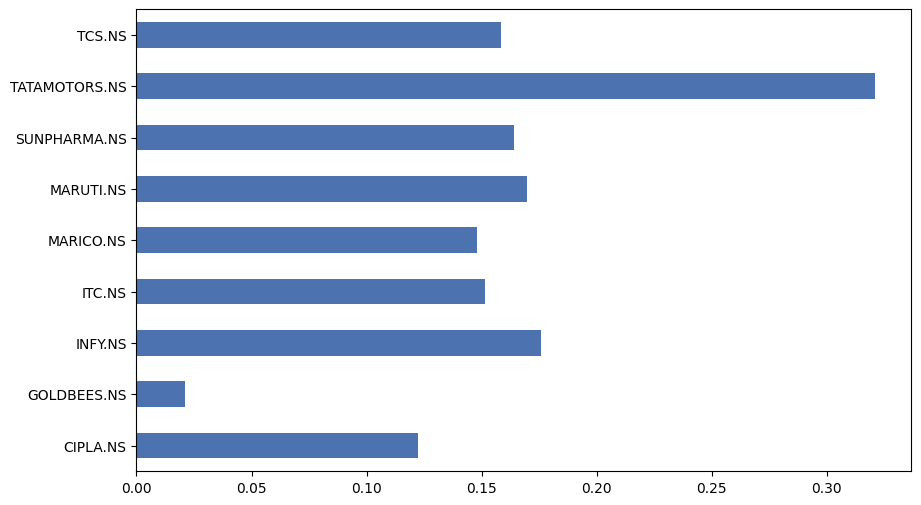

In [12]:
mu.plot.barh(figsize=(10,6));

In [13]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'CIPLA.NS': 0.1122, 'GOLDBEES.NS': 0.0905, 'INFY.NS': 0.11603, 'ITC.NS': 0.11287, 'MARICO.NS': 0.11263, 'MARUTI.NS': 0.11094, 'SUNPHARMA.NS': 0.11454, 'TATAMOTORS.NS': 0.11785, 'TCS.NS': 0.11243}


In [14]:
ef.portfolio_performance(verbose=True)

Expected annual return: 16.3%
Annual volatility: 13.3%
Sharpe Ratio: 1.08


(0.16304815817399396, 0.13301886529199183, 1.0753975224490653)

In [15]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(portfolio)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

# Number of shares of each stock to purchase
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: \u20B9{:.2f}".format(leftover))

Discrete allocation: {'TATAMOTORS.NS': 29, 'INFY.NS': 9, 'SUNPHARMA.NS': 12, 'ITC.NS': 30, 'MARICO.NS': 24, 'TCS.NS': 4, 'CIPLA.NS': 13, 'MARUTI.NS': 1, 'GOLDBEES.NS': 178}
Funds remaining: ₹414.64


In [16]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.14979522 0.17936219 0.14820763 ... 0.16773112 0.16016188 0.1555726 ]
Sample portfolio volatilities: 0       0.135333
1       0.156444
2       0.134078
3       0.253297
4       0.144297
          ...   
9995    0.150955
9996    0.179184
9997    0.143019
9998    0.136887
9999    0.128389
Length: 10000, dtype: float64


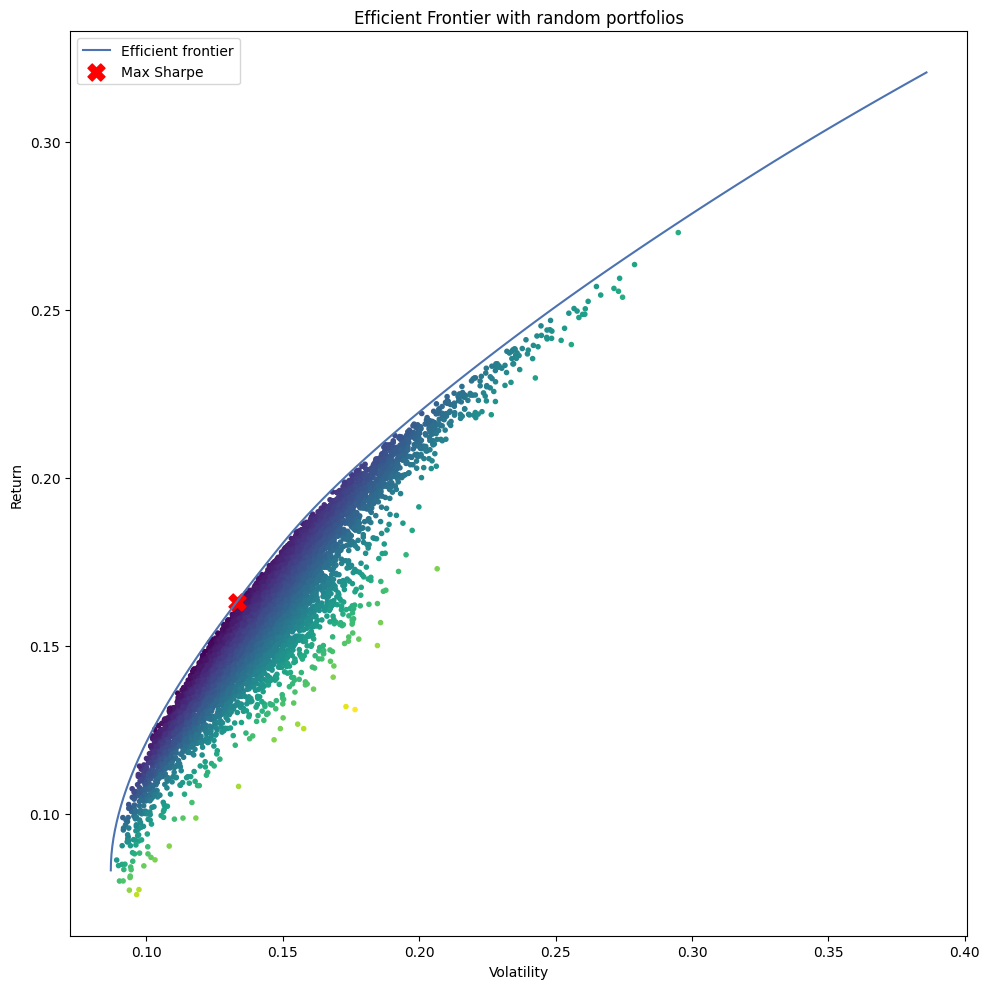

In [17]:
# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize= (10,10))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Max Sharpe')

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
